#Title

##Data Source
https://data.gov.tw/dataset/137758

## Motivation
**Ask yourself a question: What is the ultimate goal we pursue in life?**<br>
Dreams, work, marriage, and other pursuits are often influenced by financial considerations. Therefore, I aim to analyze Taiwan's financial market, study historical trends, Trying to implement for future.


##Code

###Requirments

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from dotenv import load_dotenv
import os
import requests
from google.colab import drive
import os
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
!pip install -q transformers accelerate

###Connect to google drive

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab/Data/a05018102-2120291310.csv"
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data cleaning

> Clean Strings space




In [ ]:
df.columns = df.columns.str.strip()
for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip()

>Transfer header to English

In [ ]:
col_mapping = {
    '黃金[飾金]市價[元/臺錢]': 'Gold_Price_TWD_per_TaiQian',
    '美元匯率官價[元]': 'USD_Official_Rate',
    '美元匯率市價[元]': 'USD_Market_Rate',
    '日圓匯率官價/買價[元]': 'JPY_Official_Buy',
    '日圓匯率官價/賣價[元]': 'JPY_Official_Sell',
    '日圓匯率市價[元]': 'JPY_Market_Rate',
    '港幣匯率官價/買價[元]': 'HKD_Official_Buy',
    '港幣匯率官價/賣價[元]': 'HKD_Official_Sell',
    '港幣匯率市價[元]': 'HKD_Market_Rate',
    '民間遠期支票借款平均利率[月息百分比率]': 'Private_Bill_Loan_Rate_Monthly',
    '民間信用拆借平均利率[月息百分比率]': 'Private_Credit_Lending_Rate_Monthly',
    '公定利息[每萬元月息]': 'Official_Interest_per_10000_TWD'
}
df.rename(columns = col_mapping, inplace=True)
print(df.head())

    統計期  Gold_Price_TWD_per_TaiQian  USD_Official_Rate  USD_Market_Rate  \
0  79年底                     1318.35              27.11            27.26   
1  80年底                     1233.34              25.75            26.00   
2  81年底                     1129.99              25.40            25.57   
3  82年底                     1333.31              26.63            26.99   
4  83年底                     1326.68              26.24            26.56   

   JPY_Official_Buy  JPY_Official_Sell  JPY_Market_Rate  HKD_Official_Buy  \
0              0.20               0.20             0.21              3.45   
1              0.20               0.21             0.20              3.28   
2              0.20               0.21             0.21              3.26   
3              0.24               0.24             0.25              3.42   
4              0.26               0.27             0.26              3.37   

   HKD_Official_Sell  HKD_Market_Rate  Private_Bill_Loan_Rate_Monthly  \
0            

> Year format cleaning



In [ ]:
df['Year'] = df['統計期'].str.replace('年底', '', regex=False)
print(df['Year'])

0      79
1      80
2      81
3      82
4      83
5      84
6      85
7      86
8      87
9      88
10     89
11     90
12     91
13     92
14     93
15     94
16     95
17     96
18     97
19     98
20     99
21    100
22    101
23    102
24    103
25    104
26    105
27    106
28    107
29    108
30    109
31    110
32    111
33    112
34    113
Name: Year, dtype: object


###Results

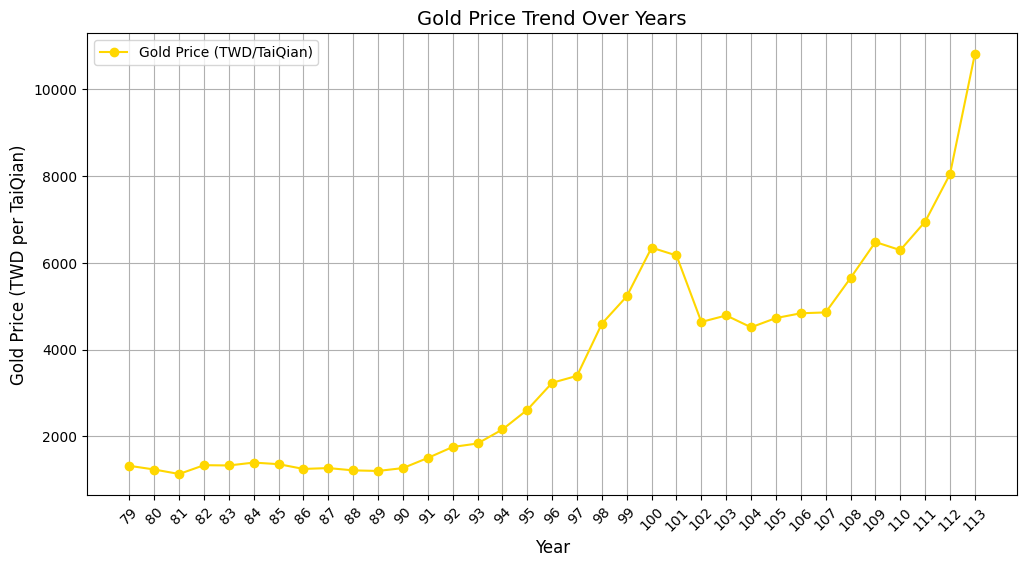

In [ ]:
x = df['Year']
y = df['Gold_Price_TWD_per_TaiQian'].astype(float)
plt.figure(figsize=(12,6))
plt.plot(x, y, marker='o', color='gold', label='Gold Price (TWD/TaiQian)')
plt.title('Gold Price Trend Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gold Price (TWD per TaiQian)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

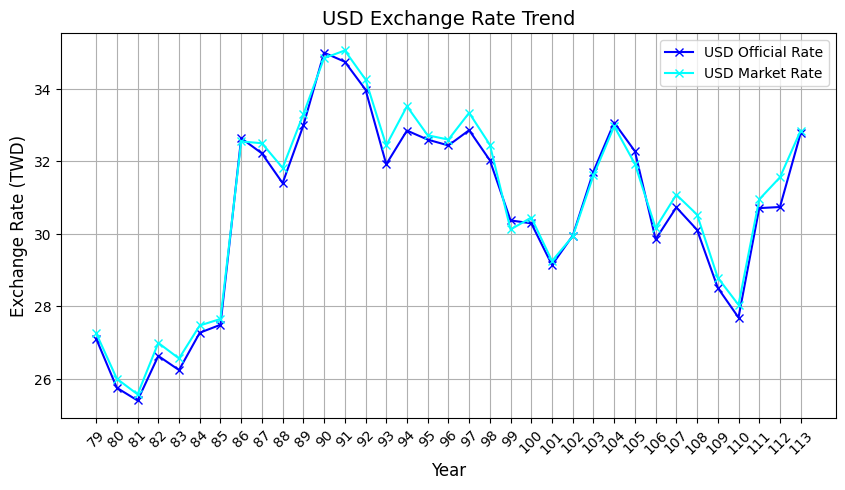

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x, df['USD_Official_Rate'], marker='x', color='blue', label='USD Official Rate')
plt.plot(x, df['USD_Market_Rate'], marker='x', color='cyan', label='USD Market Rate')
plt.title('USD Exchange Rate Trend', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Exchange Rate (TWD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

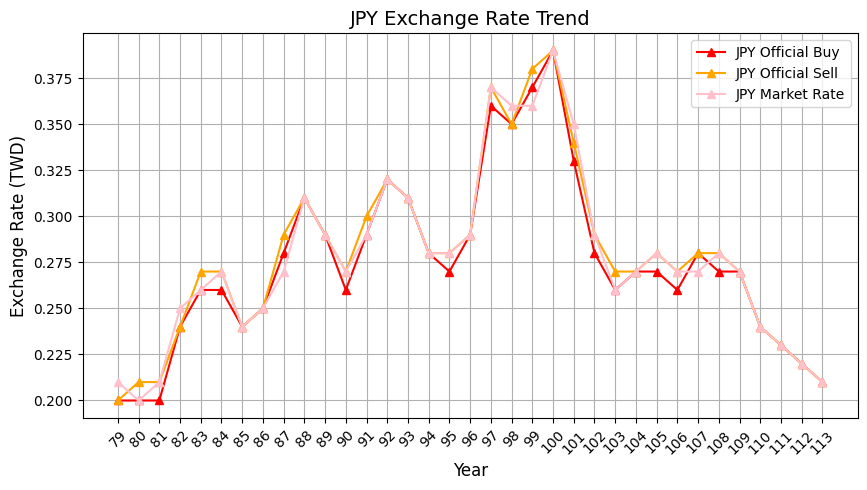

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x, df['JPY_Official_Buy'], marker='^', color='red', label='JPY Official Buy')
plt.plot(x, df['JPY_Official_Sell'], marker='^', color='orange', label='JPY Official Sell')
plt.plot(x, df['JPY_Market_Rate'], marker='^', color='pink', label='JPY Market Rate')
plt.title('JPY Exchange Rate Trend', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Exchange Rate (TWD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

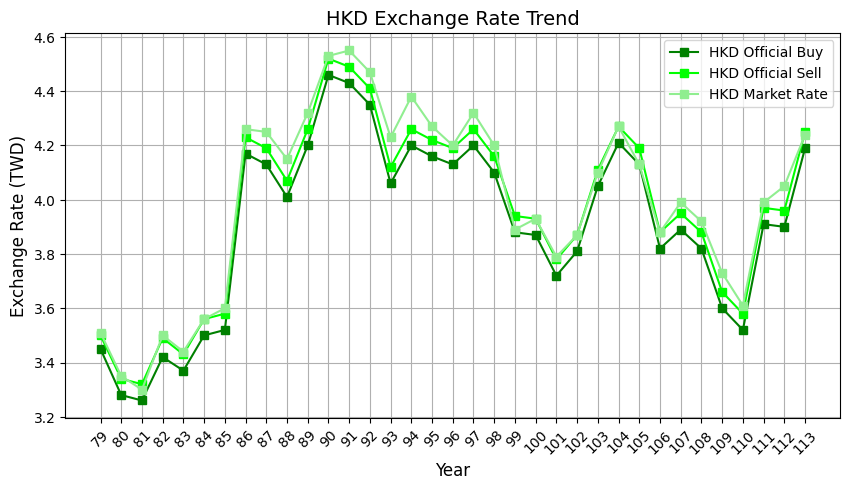

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(x, df['HKD_Official_Buy'], marker='s', color='green', label='HKD Official Buy')
plt.plot(x, df['HKD_Official_Sell'], marker='s', color='lime', label='HKD Official Sell')
plt.plot(x, df['HKD_Market_Rate'], marker='s', color='lightgreen', label='HKD Market Rate')
plt.title('HKD Exchange Rate Trend', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Exchange Rate (TWD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

###Analysis

In [ ]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
data_summary = df.to_string(index=False)

In [ ]:
def analyze_with_phi(prompt, max_new_tokens=500):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.7, #偏向創意的回答
        do_sample=True, #回答的面向不一定
        top_p=0.9, #從累積機率前 90% 的詞彙中抽取下個字，更平衡創意與合理性
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # 去除 prompt 回顯
    return response.replace(prompt, "").strip()

# CoT Prompt
prompt = f"""
You are a professional financial data analyst.

Below is summarized historical financial data from Taiwan (yearly basis):
{data_summary}

Follow a Chain-of-Thought reasoning process:
Provide a clear, structured summary in English with subheadings:
- Overview
- Key Observations
- Correlation Analysis
- Possible Economic Interpretation
- Conclusion

Begin your reasoning step-by-step and then give a concise final answer.
"""

# Analysis
result = analyze_with_phi(prompt)
print(result)


## Solution:

**Overview**
The provided dataset outlines the financial indicators of Taiwan's economy from 1979 to 2013, including Gold Price per TWD, Official Oil Rate, JPY Buy/Sell, HKD Buy/Sell, Private Bill Loan Rate, Private Bill Monthly Rate, Official Interest Rate, and Private Bill Bill Rate per 10,000 TWD.

**Key Observations**
The data shows fluctuations in all the financial indicators, with the Gold Price per TWD showing the most significant increase, rising from 27.11 TWD in 1979 to 10,816.67 TWD in 2013. In contrast, the JPY Buy/Sell rate shows the smallest change, moving from 0.20 to 0.21. Interest rates also demonstrate variations, with the Official Interest Rate peaking at 29.14% in 1979 and reaching 2.21% in 2013.

**Correlation Analysis**
Upon analyzing the data, it appears that there is a weak correlation between Gold Price per TWD and other financial indicators. While Gold Price has a clear upward trend, the other indicators do not follow a similar pattern. For examp

## Conclusion

The analysis of Taiwan's financial indicators from 1979 to 2013 reveals that all indicators experienced fluctuations over time. The Gold Price per TWD showed the most significant increase, while exchange rates such as JPY and HKD remained relatively stable. Interest rates varied considerably, with the Official Interest Rate peaking in 1979 and decreasing by 2013. Correlation analysis indicates a weak relationship between Gold Price and other financial indicators, suggesting that gold trends are influenced by factors like inflation, economic growth, and investor behavior rather than directly following other financial metrics. Overall, the dataset highlights the importance of historical trends in understanding Taiwan's financial market dynamics and potential implications for future economic decisions.
